# Classifier Diagnostics

Task: plot a confusion matrix, find images that were misclassified

## Setup

You do not need to read or modify the code in this section to successfully complete this assignment.

In [1]:
# Import fastai code.
from fastai.vision.all import *

# Set a seed for reproducibility.
set_seed(0, reproducible=True)

Monkey-patch `plot_top_losses` because of a bug.

In [2]:
def _plot_top_losses(self, k, largest=True, **kwargs):
    losses,idx = self.top_losses(k, largest)
    if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
    if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
    else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
    b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
    x,y,its = self.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
    x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses, **kwargs)
ClassificationInterpretation.plot_top_losses = _plot_top_losses

### Set up the dataset

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
image_files = get_image_files(path).sorted()

In [5]:
# Cat images have filenames that start with a capital letter.
def is_cat(filename):
    return filename[0].isupper()

### Optionally corrupt some of the image labels

In [6]:
FLIP_PROB = 0.0 # <--AFTER FINISHING, try setting this to 0.25 to play with detecting mislabeled images
correct_labels = [is_cat(path.name) for path in image_files]
corrupted_labels = [
    not correct_label if random.random() < FLIP_PROB else correct_label
    for correct_label in correct_labels]

Check how many labels are still correct.

In [7]:
sum(
    correct_label == corrupted_label
    for correct_label, corrupted_label in zip(correct_labels, corrupted_labels)
) / len(correct_labels)

1.0

### Train the classifier

In [8]:
dataloaders = ImageDataLoaders.from_lists(
    path=path, fnames=image_files, labels=corrupted_labels,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224)
)

epoch,train_loss,valid_loss,accuracy,time
0,0.179742,0.038062,0.985792,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.045842,0.019652,0.991881,00:17
1,0.041090,0.013987,0.995940,00:17
2,0.029582,0.013424,0.995264,00:17
3,0.011655,0.013154,0.995264,00:16


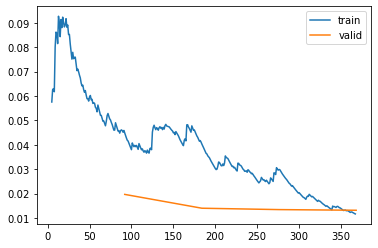

In [9]:
learn = cnn_learner(
    dls=dataloaders,
    arch=resnet18,
    metrics=accuracy
)
learn.fine_tune(epochs=4)
learn.recorder.plot_loss()

## Task

We've given you a classifier (the `learn` object). It makes a few mistakes; can you find them?

> The code above provides a way to *corrupt* some of the labels before training. For the purposes of this assignment, the corruption machinery is turned off. But you might find it enlightening to re-enable it and see how a classifier handles mislabeled data. But wait until *after you finish this assignment*.

Follow these steps:

1. Show one batch from each of the training and validation sets. (Find the `DataLoader` objects at `dataloaders.train` and `dataloaders.valid`; each of them has a `.show_batch()` method.)

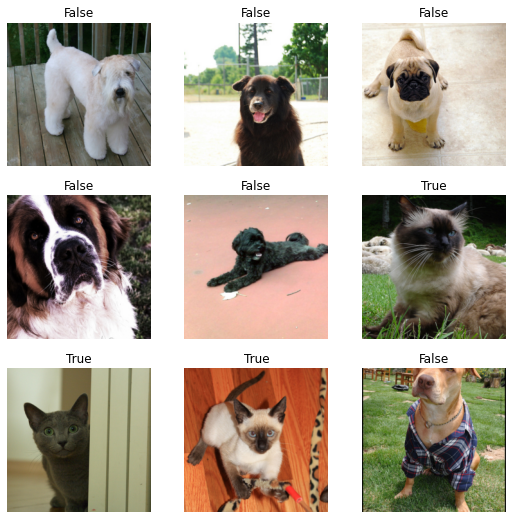

In [19]:
# your code here
dataloaders.train.show_batch()

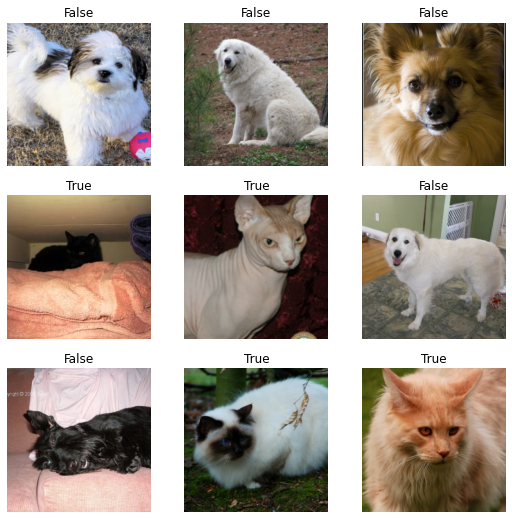

In [20]:
# your code here
dataloaders.valid.show_batch()

2. Compute the *accuracy* and *error rate* of this classifier on the validation set (`accuracy(interp.preds, interp.targs)`). Check that this number matches the last accuracy figure reported while training above. Multiply this by the number of images in the validation set to give the actual number of misclassified images.

*Hints*:

- You may need `WHATEVER.item()` to get a plain number instead of a `Tensor`.
- `DataLoader`s have a `.n` attribute that gives the number of images in them.

In [29]:
# your code here
interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
accuracy(interp.preds, interp.targs).item()

0.9952638745307922

3. Plot the confusion matrix on the validation set (see chapter 2).

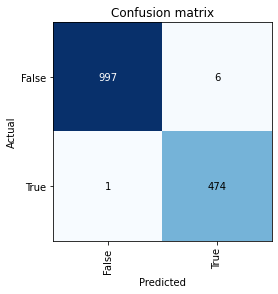

In [23]:
# your code here
interp.plot_confusion_matrix()

4. Compute the accuracy on the *training* set. (Since "dataset 0" is the training set and "dataset 1" is the validation set, we can use `interp_train = ClassificationInterpretation.from_learner(learn, ds_idx=0)`)

In [30]:
interp_train = ClassificationInterpretation.from_learner(learn, ds_idx=0)
# your code here
accuracy(interp_train.preds, interp_train.targs).item()

0.9994925856590271

5. Plot the top 12 losses in the validation set.

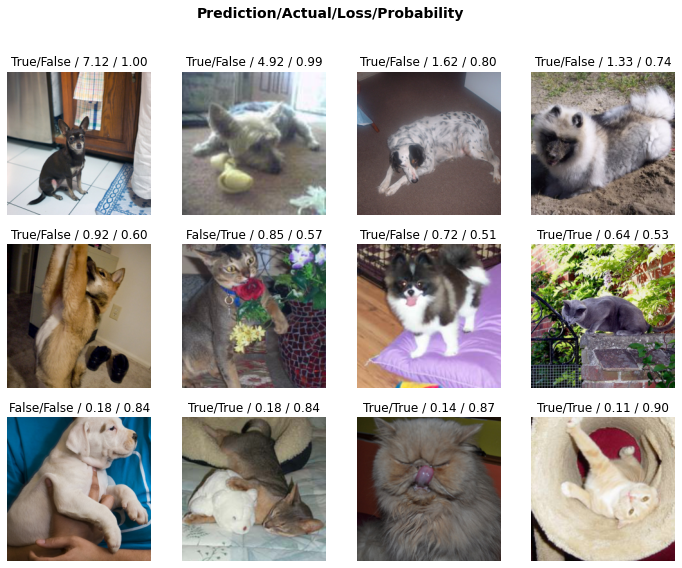

In [25]:
interp.plot_top_losses(12)

## Analysis

1. **How many dogs in the validation set were misclassified as cats? Vice versa?**

6 out of 1003 images were incorrectly labeled "cat".

1 out of 475 images were incorrectly labeled "dog".

2. **If we had only looked at the accuracy on the training set, would we have *overestimated* or *underestimated* how well the classifier would have performed on the validation set? By how much?**

In [32]:
val_accuracy =   0.9952638745307922
train_accuracy = 0.9994925856590271
(val_accuracy - train_accuracy) * 100

-0.42287111282348633

We would have overestimated by 0.4%.

3. Examine the top losses plot.
  1. Explain what the four things above each image mean.
          The first boolean value represents the predicted value. The second boolean value represents actual value. The third value represents loss. The fourth value represents probability.
  2. Explain why some correctly classified images appear in the "top losses".
          It is because the model wasn't as confident (lower probability value)
  3. What is the relationship between "loss" and "probability"?
          If the predicted value matches the actual value and the probability is high, then the loss is quite low. On the other hand, if the predicted value does not match the actual value and the probability is high, then the loss is high because of the overconfidence.